In [89]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt

In [55]:
def startsWithDate(s):
    pattern = '^([1-9]|[1-2][0-9]|(3)[0-1])(\/)([1-9]|(1)[0-2])(\/)(1)(9) ([0-9][0-9]|[0-9]):([0-9][0-9]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [54]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [53]:
def getDataPoint(line):
    # line = 18/06/19, 22:47 - Daniki: Avui se surt
    
    splitLine = line.split(' - ') # splitLine = ['18/6/19, 22:47', 'Daniki: Avui se surt']
    
    dateTime = splitLine[0] # dateTime = '18/6/19, 22:47'
    
    date, time = dateTime.split() # date = '18/6/19'; time = '22:47'
    
    message = ' '.join(splitLine[1:]) # message = 'Daniki: Avui se surt'
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Daniki', 'Avui se surt']
        author = splitMessage[0] # author = 'Daniki'
        message = ' '.join(splitMessage[1:]) # message = 'Avui se surt?'
    else:
        author = None
    return date, time, author, message

In [100]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'Chat_Qehace.txt'
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
    fp.readline()
    fp.readline()
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    while True:
        line = fp.readline() 
        if not line: # Stop reading further if end of file has been reached
            break
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces
        if startsWithDate(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer
    print(parsedData[68])

['10/3/19', '3:29', 'Rubio', 'Billion Club Avenida de Concha Espina, 39 http://www.billionclub.es/']


In [101]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df.head()

,Date,Time,Author,Message
0,7/3/19,15:03,Coto,Lokis ara he arribat a Lleida
1,7/3/19,15:08,Knuts,https://www.youtube.com/watch?v=SvXu4-WLJT8
2,7/3/19,15:09,Coto,Jajaja ja marxo
3,7/3/19,15:44,Daniki,Estic currant a la csa colonies jo
4,7/3/19,15:45,Daniki,Fins div d la setman vinent re


In [102]:
df.describe()

,Date,Time,Author,Message
count,1034,1034,1020,1034
unique,34,419,12,879
top,20/4/19,13:08,Knuts,<Multimedia omitido>
freq,139,22,201,109


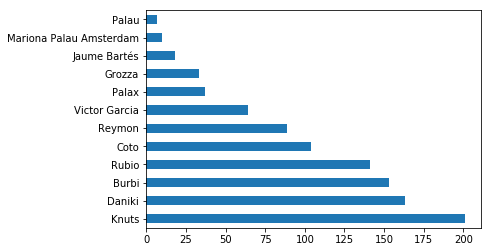

In [103]:
author_value_counts = df['Author'].value_counts() # Number of messages per author
#author_value_counts = author_value_counts.head(10) # Number of messages per author for the top 10 most active authors
author_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis

In [104]:
null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()

,Date,Time,Author,Message
189,18/3/19,17:43,None,‎Rubio añadió a Mariona Palau Amsterdam
504,18/4/19,20:57,None,‎Daniki cambió el ícono de este grupo
505,18/4/19,20:57,None,‎Daniki cambió el ícono de este grupo
506,18/4/19,20:58,None,‎Daniki cambió el ícono de este grupo
507,18/4/19,20:58,None,‎Coto cambió el ícono de este grupo


       Date   Time  Author               Message
22   8/3/19  18:42  Daniki  <Multimedia omitido>
40   9/3/19  18:21   Rubio  <Multimedia omitido>
49   9/3/19  19:30   Knuts  <Multimedia omitido>
59  10/3/19   2:16    Coto  <Multimedia omitido>
60  10/3/19   2:25   Rubio  <Multimedia omitido>


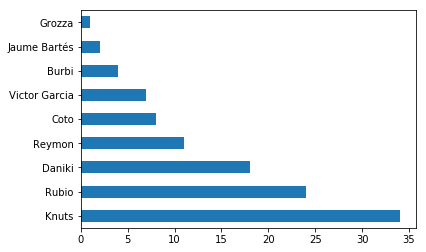

In [106]:
media_messages_df = df[df['Message'] == '<Multimedia omitido>']
print(media_messages_df.head())

author_media_messages_value_counts = media_messages_df['Author'].value_counts()
top_10_author_media_messages_value_counts = author_media_messages_value_counts.head(10)
top_10_author_media_messages_value_counts.plot.barh()

In [107]:
messages_df = df.drop(null_authors_df.index) # Drops all rows of the data frame containing messages from null authors
messages_df = messages_df.drop(media_messages_df.index) # Drops all rows of the data frame containing media messages
messages_df.head()

,Date,Time,Author,Message
0,7/3/19,15:03,Coto,Lokis ara he arribat a Lleida
1,7/3/19,15:08,Knuts,https://www.youtube.com/watch?v=SvXu4-WLJT8
2,7/3/19,15:09,Coto,Jajaja ja marxo
3,7/3/19,15:44,Daniki,Estic currant a la csa colonies jo
4,7/3/19,15:45,Daniki,Fins div d la setman vinent re


In [110]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df.head()

,Date,Time,Author,Message,Letter_Count,Word_Count
0,7/3/19,15:03,Coto,Lokis ara he arribat a Lleida,29,6
1,7/3/19,15:08,Knuts,https://www.youtube.com/watch?v=SvXu4-WLJT8,43,1
2,7/3/19,15:09,Coto,Jajaja ja marxo,15,3
3,7/3/19,15:44,Daniki,Estic currant a la csa colonies jo,34,7
4,7/3/19,15:45,Daniki,Fins div d la setman vinent re,30,7


In [119]:
discrete_columns = ['Date', 'Time', 'Author', 'Message']
messages_df[discrete_columns].describe()

,Date,Time,Author,Message
count,911,911,911,911
unique,33,383,12,875
top,20/4/19,19:48,Knuts,?
freq,132,14,167,6


In [120]:
continuous_columns = ['Letter_Count', 'Word_Count']
messages_df[continuous_columns].describe()

,Letter_Count,Word_Count
count,911.000000,911.000000
mean,21.106476,4.459934
std,25.885476,4.784624
min,1.000000,1.000000
25%,9.000000,2.000000
50%,17.000000,4.000000
75%,27.000000,6.000000
max,639.000000,110.000000


In [121]:
messages_df['Letter_Count'].sum(), messages_df['Word_Count'].sum()

(19228, 4063)

Text(0, 0.5, 'Authors')

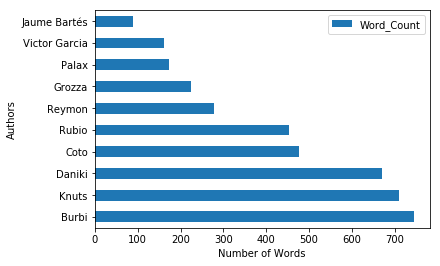

In [122]:
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(10)
top_10_sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

In [131]:
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_20_word_count_value_counts = word_count_value_counts.head(20)
top_20_word_count_value_counts

1     159
2     155
3     131
4     130
5      88
6      71
7      49
9      36
8      22
11     20
10     17
12      9
13      5
17      5
16      4
14      3
15      3
24      1
18      1
21      1
Name: Word_Count, dtype: int64

Text(0, 0.5, 'Frequency')

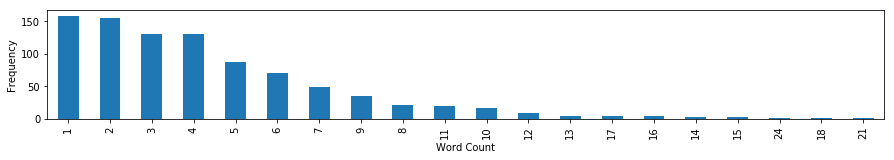

In [129]:
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
top_20_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Authors')

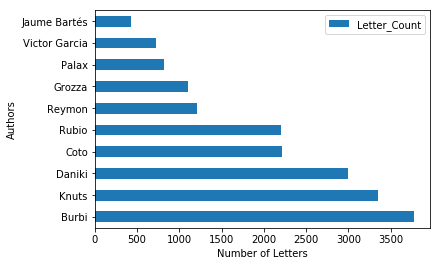

In [126]:
total_letter_count_grouped_by_author = messages_df[['Author', 'Letter_Count']].groupby('Author').sum()
sorted_total_letter_count_grouped_by_author = total_letter_count_grouped_by_author.sort_values('Letter_Count', ascending=False)
top_10_sorted_total_letter_count_grouped_by_author = sorted_total_letter_count_grouped_by_author.head(10)
top_10_sorted_total_letter_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Letters')
plt.ylabel('Authors')

Text(0, 0.5, 'Frequency')

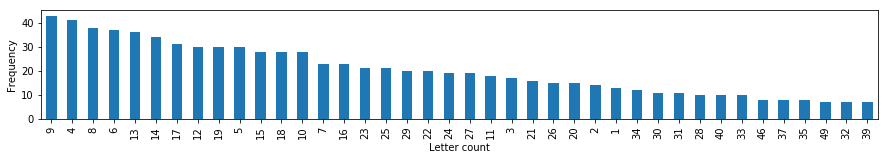

In [127]:
plt.figure(figsize=(15, 2))
letter_count_value_counts = messages_df['Letter_Count'].value_counts()
top_40_letter_count_value_counts = letter_count_value_counts.head(40)
top_40_letter_count_value_counts.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Date')

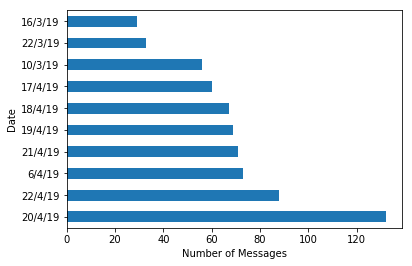

In [132]:
messages_df['Date'].value_counts().head(10).plot.barh() # Top 10 Dates on which the most number of messages were sent
plt.xlabel('Number of Messages')
plt.ylabel('Date')

Text(0, 0.5, 'Time')

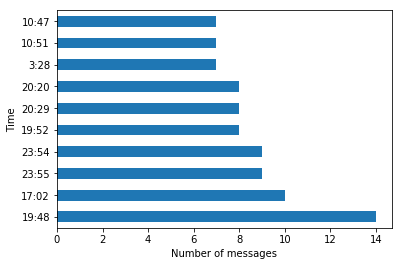

In [133]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

In [135]:
messages_df['Hour'] = messages_df['Time'].apply(lambda x : x.split(':')[0]) 
# The first token of a value in the Time Column contains the hour (Eg., "20" in "20:15")
messages_df.head()

,Date,Time,Author,Message,Letter_Count,Word_Count,Hour
0,7/3/19,15:03,Coto,Lokis ara he arribat a Lleida,29,6,15
1,7/3/19,15:08,Knuts,https://www.youtube.com/watch?v=SvXu4-WLJT8,43,1,15
2,7/3/19,15:09,Coto,Jajaja ja marxo,15,3,15
3,7/3/19,15:44,Daniki,Estic currant a la csa colonies jo,34,7,15
4,7/3/19,15:45,Daniki,Fins div d la setman vinent re,30,7,15


Text(0, 0.5, 'Hour of Day')

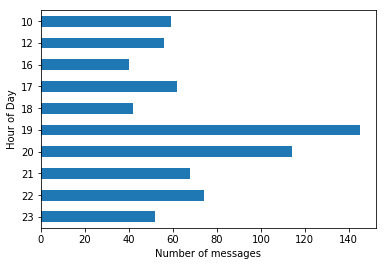

In [138]:
messages_df['Hour'].value_counts().head(10).sort_index(ascending=False).plot.barh() # Top 10 Hours of the day during which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

In [ ]:
#Now I want to group all messages of one same person in order to perform a Personality Insights out of them